In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import torch
import re
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models


# Data

##Def

In [3]:
def extract_ids(image_folder:str, ann_file:str):
  """
    return final_ids which is in pic and ann file
    image_folder: path to the image folder
    ann_file: path to the annotation file
  """
  coco = COCO(ann_file)
  # List of ids in ann
  img_ids = coco.getImgIds()

  # path of images
  image_list = os.listdir(image_folder)
  id_list = []
  for image_name in image_list:
    if image_name.endswith(".jpg") or image_name.endswith(".jpeg"):
      # Extracting ID using regular expression
      match = re.search(r'\d+', image_name)
      if match:
        image_id = int(match.group())
        id_list.append(image_id)

  # Intersection of two list
  final_id = list(set(img_ids) & set(id_list))

  return final_id

def one_label_COCO(image_folder:str, ann_file:str):
  """
    return image id and uniq label (Select the class with the largest number of objects)
    image_folder: path to the image folder
    ann_file: path to the annotation file
  """
  # retirn final_ids which is in pic and ann file
  image_ids = extract_ids(image_folder, ann_file)
  # Define coco
  coco = COCO(ann_file)

  # Create a dictionary to store the final labels
  img_to_label = {}

  # Processing each image
  for img_id in image_ids:
      # Get image annotations
      ann_ids = coco.getAnnIds(imgIds=img_id)
      anns = coco.loadAnns(ann_ids)

      # Count the number of objects of each class
      class_counts = {}
      for ann in anns:
          class_id = ann['category_id']
          class_counts[class_id] = class_counts.get(class_id, 0) + 1

      # Select the class with the largest number of objects.
      if class_counts:
          dominant_class = max(class_counts, key=class_counts.get)
          img_to_label[img_id] = dominant_class
      else:
          img_to_label[img_id] = None  # If the image has no objects

  #Sort Dict by id
  img_to_label = dict(sorted(img_to_label.items()))

  return img_to_label

def onehot_labels(my_dict:dict, num_classes:int):
  """
  changes the dictionary which has id and classes to one hot array
  my_dict: main dictionary
  num_classes: number of classes
  """
  # Number of classes
  num_classes = num_classes
  # Create a 2D array of the form (number of data, num_classes)
  num_data = len(my_dict)
  onehot_array = np.zeros((num_data, num_classes))
  # Converting a dictionary to a one-hot two-dimensional array
  for idx, (key, val) in enumerate(my_dict.items()):
      onehot_array[idx][val] = 1
  return onehot_array


def pic_preproc_Intersection(image_folder:str, ann_file:str, size: int):
  """
  resize and add 1 dimention to the image.  return just Intersection images.
  image_folder: path to the image folder
  ann_file: path to the annotation file
  size: size of Length and width
  """
  id_Intersection = extract_ids(image_folder, ann_file)
  # A list to save the paths of the desired images
  filtered_image_paths = []

  # Reading image paths
  image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.lower().endswith(".jpg")]

  # Filter image paths based on IDs in id_Intersection
  for image_path in image_paths:
      image_name = os.path.basename(image_path)
      id_number = int(image_name.split('.')[0])  #Extracting ID from image name
      if id_number in id_Intersection:
          filtered_image_paths.append(image_path)  # Add image path to filtered list
  # Sort the path
  filtered_image_paths.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
  print(filtered_image_paths)
  #####Preprocess function
  all_images = []
  # main function
  for img_path in filtered_image_paths:
      img = cv2.imread(img_path)
      gray_img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      resized_img = cv2.resize(gray_img1, (size, size))
      gray_img2 = resized_img[:, :, np.newaxis]
      # Normalize pixel values to be between 0 and 1
      gray_img2 = gray_img2 / 255.0

      # Add processed image to list
      all_images.append(gray_img2)
  # Convert list to NumPy array
  all_pic = np.array(all_images)

  return all_pic

def pic_preproc_Intersection_3chan(image_folder:str, ann_file:str, size: int):
  """
  resize the image.  return just Intersection images.
  image_folder: path to the image folder
  ann_file: path to the annotation file
  size: size of Length and width
  """
  id_Intersection = extract_ids(image_folder, ann_file)
  # A list to save the paths of the desired images
  filtered_image_paths = []

  # Reading image paths
  image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.lower().endswith(".jpg")]

  # Filter image paths based on IDs in id_Intersection
  for image_path in image_paths:
      image_name = os.path.basename(image_path)
      id_number = int(image_name.split('.')[0])  #Extracting ID from image name
      if id_number in id_Intersection:
          filtered_image_paths.append(image_path)  # Add image path to filtered list
  # Sort the path
  filtered_image_paths.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
  print(filtered_image_paths)
  #####Preprocess function
  all_images = []
  # main function
  for img_path in filtered_image_paths:
      img = cv2.imread(img_path)
      resized_img = cv2.resize(img, (size, size))
      # Normalize pixel values to be between 0 and 1
      resized_img = resized_img / 255.0
      # Add processed image to list
      all_images.append(resized_img)
  # Convert list to NumPy array
  all_pic = np.array(all_images)

  return all_pic

def train_test_splitt(x_all:np.ndarray, y_all:np.ndarray, test_ratio:float):
  """
  split train and test. for x and y
  x_all: x data (input pic)
  y_all: y data (label)
  test_ratio:  test ratio (float)
  """
  # Splitting the data into train and test with a ratio of 80 to 20 percent
  x_train, x_test, y_train, y_test,  = train_test_split(x_all,y_all, test_size=test_ratio , random_state=42)
  return x_train, x_test, y_train, y_test


In [4]:

image_folder = "/content/drive/MyDrive/Ai_Lab/data/coco/pic"
ann_file = '/content/drive/MyDrive/Ai_Lab/data/coco/annotations_small/instances_val2017.json'
my_dicc = one_label_COCO(image_folder, ann_file)

my_dict = my_dicc
num_classes = 183
y_all=onehot_labels(my_dict, num_classes)

loading annotations into memory...
Done (t=4.34s)
creating index...
index created!
loading annotations into memory...
Done (t=1.40s)
creating index...
index created!


In [5]:
image_folder = "/content/drive/MyDrive/Ai_Lab/data/coco/pic"
ann_file = '/content/drive/MyDrive/Ai_Lab/data/coco/annotations_small/instances_val2017.json'
size = 224
x_all = pic_preproc_Intersection_3chan(image_folder, ann_file, size)

loading annotations into memory...
Done (t=1.62s)
creating index...
index created!
['/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000000139.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000000285.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000000632.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000002592.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000002685.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000002923.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000003156.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000003255.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000003501.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000003553.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000003661.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000003845.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000003934.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000004134.jpg', '/content/drive/MyDr

In [6]:
x_al=x_all
y_al = y_all
test_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_splitt(x_al, y_al, test_ratio)

min_pixel_value = 0
max_pixel_value = 1
print ("min_pixel_value =" , min_pixel_value, "," , "max_pixel_value =" , max_pixel_value)
print ("x_train.shape =" , x_train.shape, "," , "y_train =" , y_train.shape)

min_pixel_value = 0 , max_pixel_value = 1
x_train.shape = (37, 224, 224, 3) , y_train = (37, 183)


# Models

In [7]:
# CNN2D model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(183, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 183)                 │          93,879 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,772,407 (37.28 MB)

 Trainable params: 9,772,407 (37.28 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Model training
history = model.fit(x_train, y_train, epochs=10, batch_size=4, validation_data=(x_test, y_test))

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 582ms/step - accuracy: 0.1708 - loss: 5.4404 - val_accuracy: 0.7000 - val_loss: 4.1507
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2923 - loss: 4.2733 - val_accuracy: 0.7000 - val_loss: 2.4593
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3467 - loss: 3.4112 - val_accuracy: 0.7000 - val_loss: 2.0687
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2829 - loss: 3.5664 - val_accuracy: 0.7000 - val_loss: 2.4925
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2544 - loss: 3.0063 - val_accuracy: 0.7000 - val_loss: 2.5746
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4007 - loss: 2.5788 - val_accuracy: 0.7000 - val_loss: 2.9558
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4148 - loss: 2.5048 - val_accuracy: 0.7000 - val_loss: 2.7457
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4737 - loss: 2.0581 - val_accuracy: 0.7000 -

In [10]:
# Model evaluation
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"test_acc: {test_acc:.4f}")

1/1 - 1s - 988ms/step - accuracy: 0.7000 - loss: 2.7116
test_acc: 0.7000


#Make ADV

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [12]:
# Helper function to preprocess the image
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image


In [13]:
image_path =  "/content/drive/MyDrive/Ai_Lab/data/Yazdanian/simple/51101054.jpg"
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = preprocess(image)
image_probs = model.predict(image)

print("image.shape:", image.shape)
print("image_probs.shape:", image_probs.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
image.shape: (1, 224, 224, 3)
image_probs.shape: (1, 183)


In [14]:
# Get the input label of the image.
#True label of image
labrador_retriever_index = 5
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

In [35]:
def fgsm_attack(model, input_image, input_label,  epsilon):
  """
  Implementing the FGSM attack to create a destructive instance
  model: Deep learning model
  input_image: Input image (TensorFlow tensor)
  input_label: Correct label (TensorFlow tensor)
  epsilon: Attack intensity (ε)
  """
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = tf.keras.losses.CategoricalCrossentropy()(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  perturbations = signed_grad
  # add attack to the pic
  adv_x = image + epsilon*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  return adv_x, perturbations


def pgd_attack(model, input_image, input_label, epsilon, alpha, num_iterations):
  """
  Implementing the PGD attack to create a destructive instance
  model: Deep learning model
  input_image: Input image (TensorFlow tensor)
  input_label: Correct label (TensorFlow tensor)
  epsilon: Attack intensity (ε)
  alpha: Step size per iteration (α)
  num_iterations: Number of iterations (T).
  """
  # Destructive image initialization
  adversarial_image = input_image + tf.random.uniform(input_image.shape, -epsilon, epsilon)
  adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)  # محدود کردن به [0, 1]

  for _ in range(num_iterations):
      with tf.GradientTape() as tape:
          tape.watch(adversarial_image)
          prediction = model(adversarial_image)
          loss = tf.keras.losses.CategoricalCrossentropy()(input_label, prediction)

      # Calculating gradients
      gradient = tape.gradient(loss, adversarial_image)
      # Calculating the sign of gradients
      signed_grad = tf.sign(gradient)
      perturbations = signed_grad
      # Destructive image update
      adversarial_image = adversarial_image + alpha * signed_grad
      # Projecting within the permitted limits
      adversarial_image = tf.clip_by_value(adversarial_image, input_image - epsilon, input_image + epsilon)
      adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)  # محدود کردن به [0, 1]

  return adversarial_image, perturbations

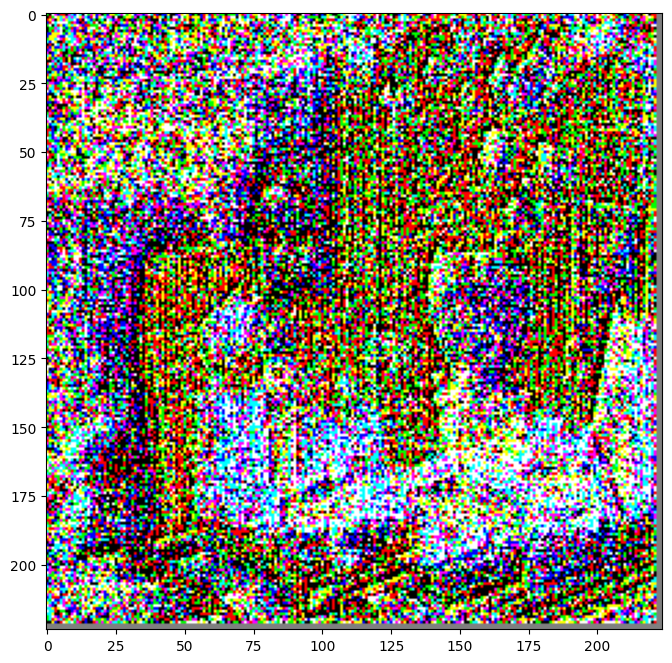

In [37]:
#FGSM
model = model
input_image = image
input_label = label
eps = 0.1
adv_x,perturbations =fgsm_attack(model, input_image, input_label,  eps)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

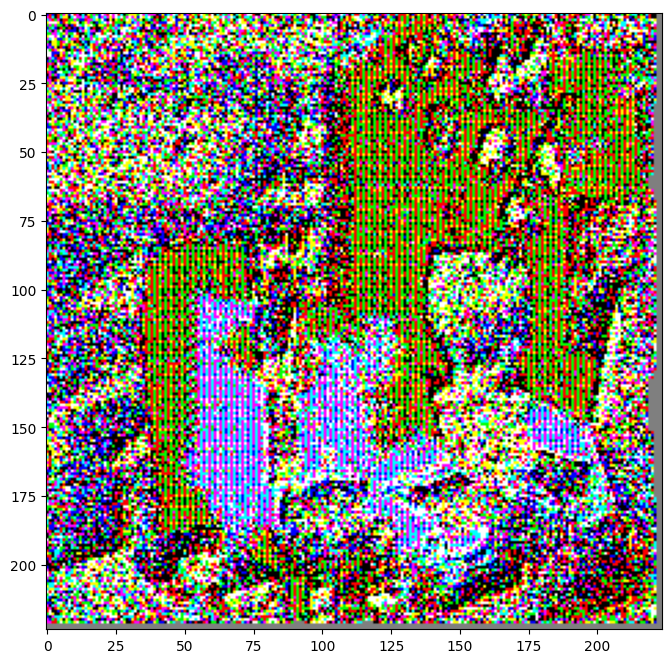

In [40]:
#PGD
model = model
input_image = image
input_label = label
epsilon = 0.1
alpha = epsilon / 4
num_iterations = 10
adv_x, perturbations =pgd_attack(model, input_image, input_label, epsilon, alpha, num_iterations)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

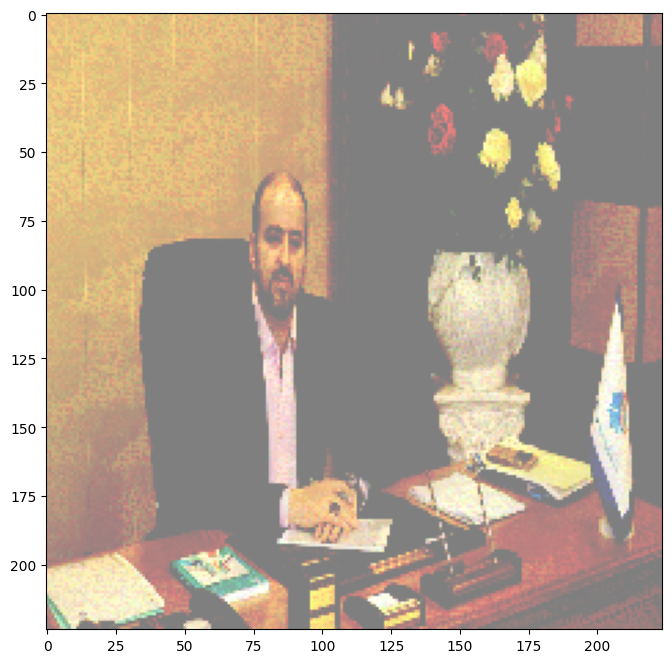

In [41]:

def display_images(adv_x, save_path):
  """
  display_images and save the pic
  adv_x: adversal image
  save_path: path to save the image (.jpg)
  """
  adv_x=adv_x[0]*0.5+0.5
  if save_path:
    plt.imsave(save_path, adv_x.numpy())
  plt.figure()
  plt.imshow(adv_x)
  plt.show()

adv_x = adv_x
save_path = '/content/drive/MyDrive/Ai_Lab/data/Yazdanian/yazdanian_attack_PGD/51101054.jpg'
display_images(adv_x, save_path)
